c:\Users\tanka\Python\SQL\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

--- All-In-One SQLi Comparative Results ---
              Model  Accuracy   Recall  F1 Score  Latency (ms)
    CNN-LSTM Hybrid  0.997221 0.993412  0.996256      0.072568
 Bidirectional LSTM  0.995096 0.989460  0.993386      0.503739
      Random Forest  0.994606 0.987703  0.992717      0.018071
        GRU Network  0.994116 0.984629  0.992035      0.278563
      Decision Tree  0.993135 0.987703  0.990749      0.000164
                KNN  0.993135 0.985068  0.990724      0.314996
            XGBoost  0.992481 0.982433  0.989823      0.000677
       SVM (Linear)  0.969925 0.941151  0.958837      0.040614
     SGD Classifier  0.951945 0.891963  0.932507      0.000000
Logistic Regression  0.949984 0.886693  0.929558      0.000000
           AdaBoost  0.938705 0.855072  0.912157      0.003541
        Naive Bayes  0.925302 0.808959  0.889640      0.000000


C:\Users\tanka\AppData\Local\Temp\ipykernel_14944\2846777589.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=sorted_df, palette='viridis')


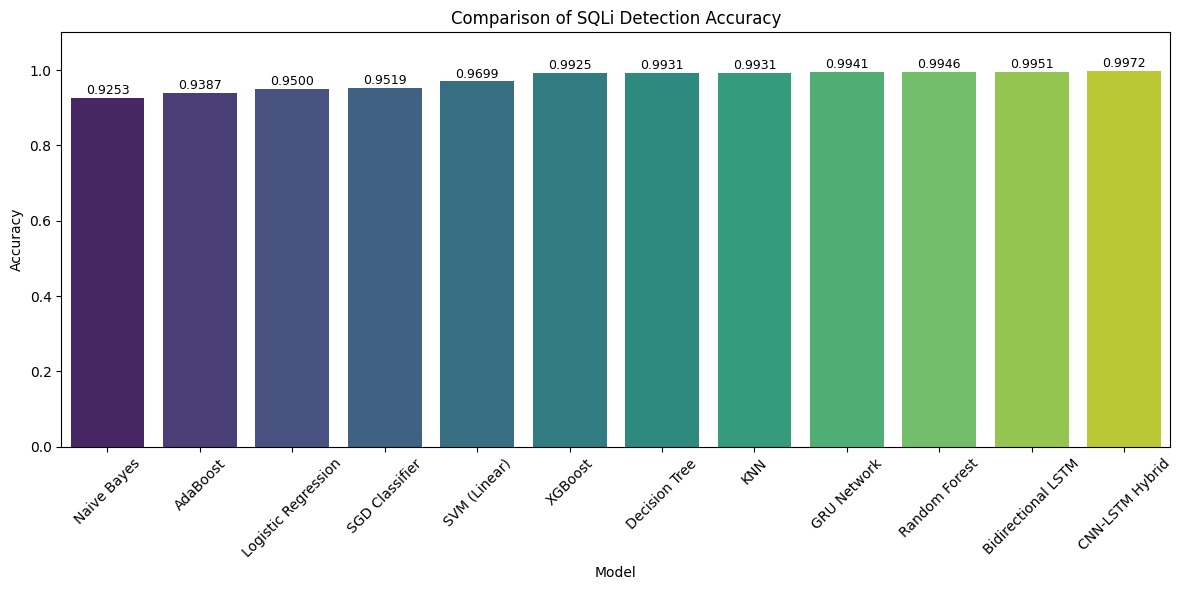

C:\Users\tanka\AppData\Local\Temp\ipykernel_14944\2846777589.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=sorted_df, palette='viridis')


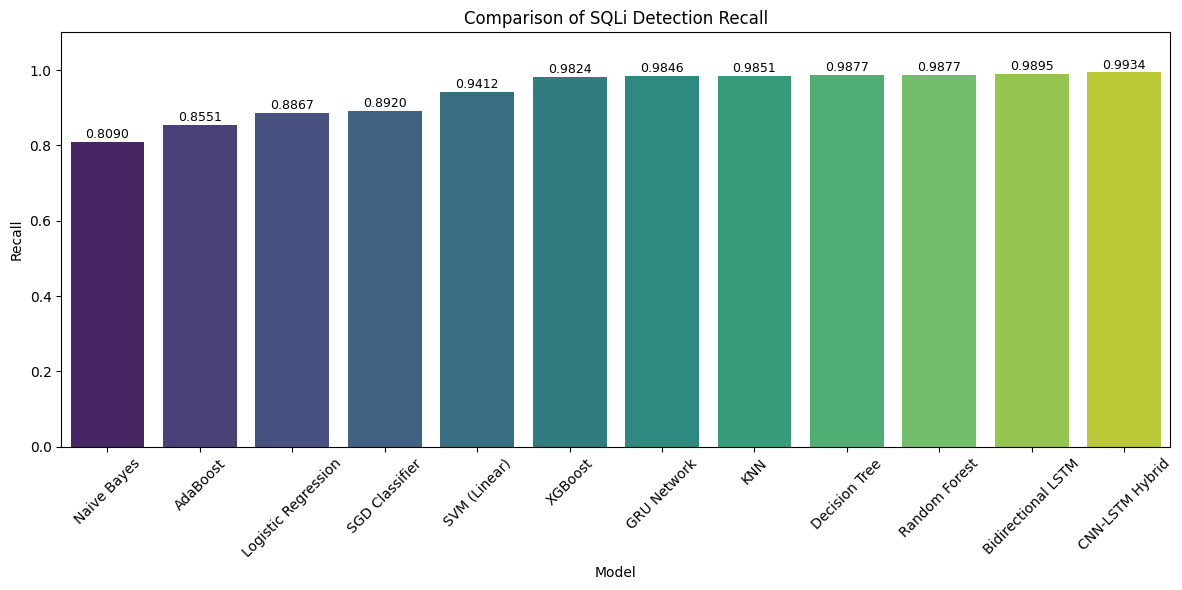

C:\Users\tanka\AppData\Local\Temp\ipykernel_14944\2846777589.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=sorted_df, palette='viridis')


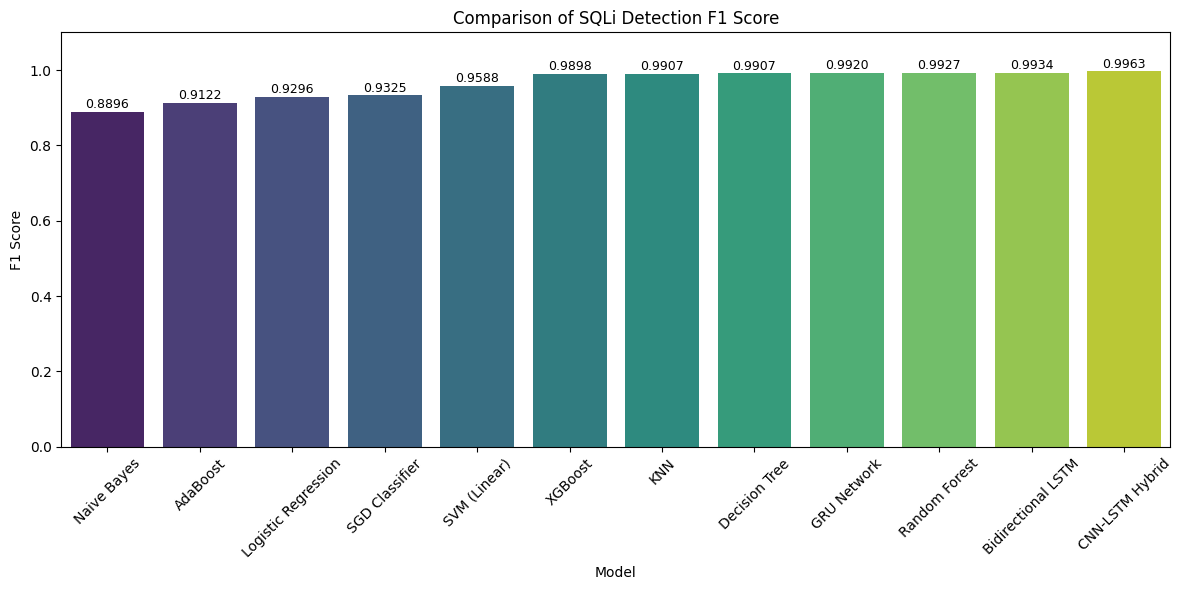

C:\Users\tanka\AppData\Local\Temp\ipykernel_14944\2846777589.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Latency (ms)', data=report_df.sort_values('Latency (ms)'), palette='magma')


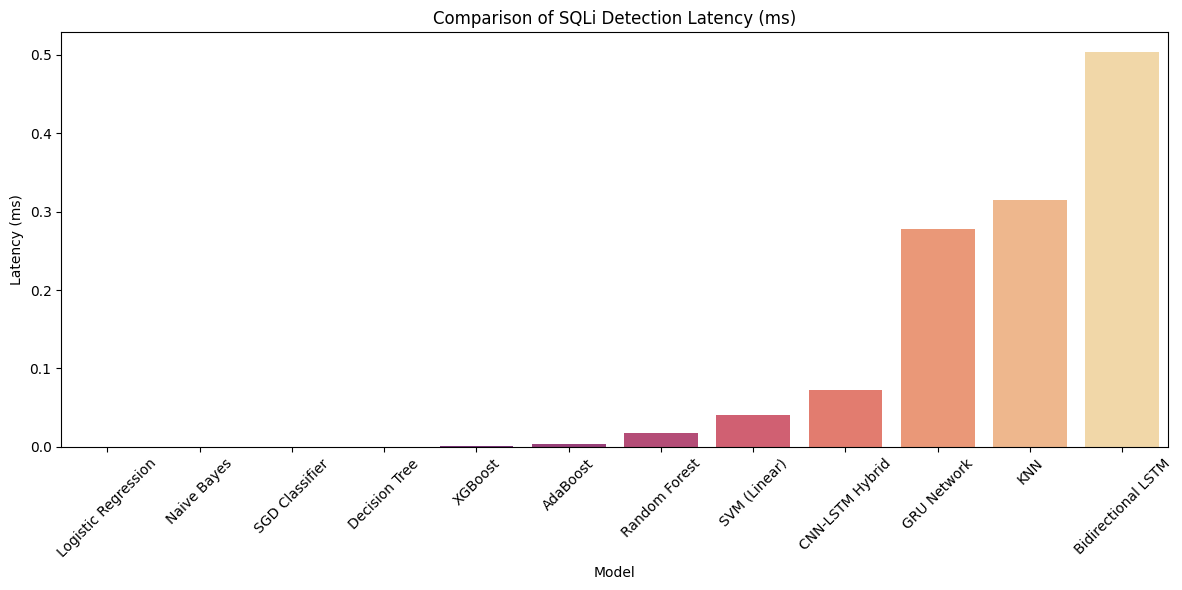

In [3]:
import pandas as pd
import numpy as np
import time, os, kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn (Traditional ML)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# TensorFlow/Keras (Deep Learning)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Bidirectional

# 1. LOAD & ADVANCED CLEANING
path = kagglehub.dataset_download("syedsaqlainhussain/sql-injection-dataset")
df = pd.read_csv(os.path.join(path, "SQLiV3.csv"))

df.drop_duplicates(subset=['Sentence'], inplace=True)
df['Label'] = pd.to_numeric(df['Label'], errors='coerce')
df.dropna(subset=['Sentence', 'Label'], inplace=True)
df['Label'] = df['Label'].astype(int)

# --- TRACK A: TRADITIONAL ML ---
tfidf = TfidfVectorizer(lowercase=True, stop_words=None, max_features=5000)
X_ml = tfidf.fit_transform(df['Sentence'])
y = df['Label']
X_train_ml, X_test_ml, y_train, y_test = train_test_split(X_ml, y, test_size=0.2, random_state=42)

selector = SelectKBest(chi2, k=1000)
X_train_fs = selector.fit_transform(X_train_ml, y_train)
X_test_fs = selector.transform(X_test_ml)

# --- TRACK B: DEEP LEARNING ---
tokenizer = Tokenizer(num_words=5000, char_level=False)
tokenizer.fit_on_texts(df['Sentence'])
X_dl = pad_sequences(tokenizer.texts_to_sequences(df['Sentence']), maxlen=150)
X_train_dl, X_test_dl, _, _ = train_test_split(X_dl, y, test_size=0.2, random_state=42)

performance_summary = []

# --- 2. TRADITIONAL ML SUITE ---
ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM (Linear)": SVC(kernel='linear'),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SGD Classifier": SGDClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "AdaBoost": AdaBoostClassifier()
}

for name, clf in ml_models.items():
    clf.fit(X_train_fs, y_train)
    start = time.time()
    preds = clf.predict(X_test_fs)
    latency = ((time.time() - start) / len(y_test)) * 1000
    performance_summary.append({
        "Model": name, 
        "Accuracy": accuracy_score(y_test, preds),
        "Recall": recall_score(y_test, preds), 
        "F1 Score": f1_score(y_test, preds), # <--- ADDED F1 SCORE
        "Latency (ms)": latency
    })

# --- 3. DEEP LEARNING SUITE ---
def build_cnn_lstm():
    model = Sequential([
        Embedding(5000, 64, input_length=150),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_bilstm():
    model = Sequential([
        Embedding(5000, 64),
        Bidirectional(LSTM(64)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru():
    model = Sequential([
        Embedding(5000, 64, input_length=150),
        GRU(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

dl_architectures = {
    "CNN-LSTM Hybrid": build_cnn_lstm(),
    "Bidirectional LSTM": build_bilstm(),
    "GRU Network": build_gru()
}

for name, model in dl_architectures.items():
    model.fit(X_train_dl, y_train, epochs=2, batch_size=64, verbose=0)
    start = time.time()
    preds = (model.predict(X_test_dl) > 0.5).astype(int)
    latency = ((time.time() - start) / len(y_test)) * 1000
    performance_summary.append({
        "Model": name, 
        "Accuracy": accuracy_score(y_test, preds),
        "Recall": recall_score(y_test, preds), 
        "F1 Score": f1_score(y_test, preds), # <--- ADDED F1 SCORE
        "Latency (ms)": latency
    })

# --- FINAL RESULTS ---
report_df = pd.DataFrame(performance_summary).sort_values(by="Accuracy", ascending=False)
print("\n--- All-In-One SQLi Comparative Results ---")
print(report_df.to_string(index=False))

# --- UPDATED VISUALIZATION SECTION ---

# Define the metrics you want to plot
metrics = ['Accuracy', 'Recall', 'F1 Score']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    # Sorting by the specific metric to make the bar chart easier to read
    sorted_df = report_df.sort_values(metric)
    
    sns.barplot(x='Model', y=metric, data=sorted_df, palette='viridis')
    
    plt.xticks(rotation=45)
    plt.title(f'Comparison of SQLi Detection {metric}')
    
    # FIX: Changed ylim from (0.9, 1.0) to (0, 1.1) 
    # This shows the full scale and leaves a little room at the top for labels
    plt.ylim(0, 1.1) 
    
    # Optional: Add text labels on top of bars for exact values
    for i, val in enumerate(sorted_df[metric]):
        plt.text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# Separate plot for Latency as it uses a different scale (milliseconds)
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Latency (ms)', data=report_df.sort_values('Latency (ms)'), palette='magma')
plt.xticks(rotation=45)
plt.title('Comparison of SQLi Detection Latency (ms)')
plt.tight_layout()
plt.show()